In [13]:
#mounting the dataset

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#Extract ZIP File
import zipfile
import os

zip_file_path = "/content/drive/MyDrive/archive (2).zip"
extract_dir = "/content"

if os.path.exists(zip_file_path):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file_path}' is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"Error: '{zip_file_path}' does not exist.")

Successfully extracted '/content/drive/MyDrive/archive (2).zip' to '/content'


In [26]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2,random

In [27]:
#Load Data
train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

img_size = 224
batch_size = 32


datagen_args = dict(rescale=1./255, validation_split=0.1)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_args, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_args)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True)

val_gen = val_test_datagen.flow_from_directory(
    valid_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False)

test_gen = val_test_datagen.flow_from_directory(
    valid_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', shuffle=False)



Found 63282 images belonging to 38 classes.
Found 1742 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


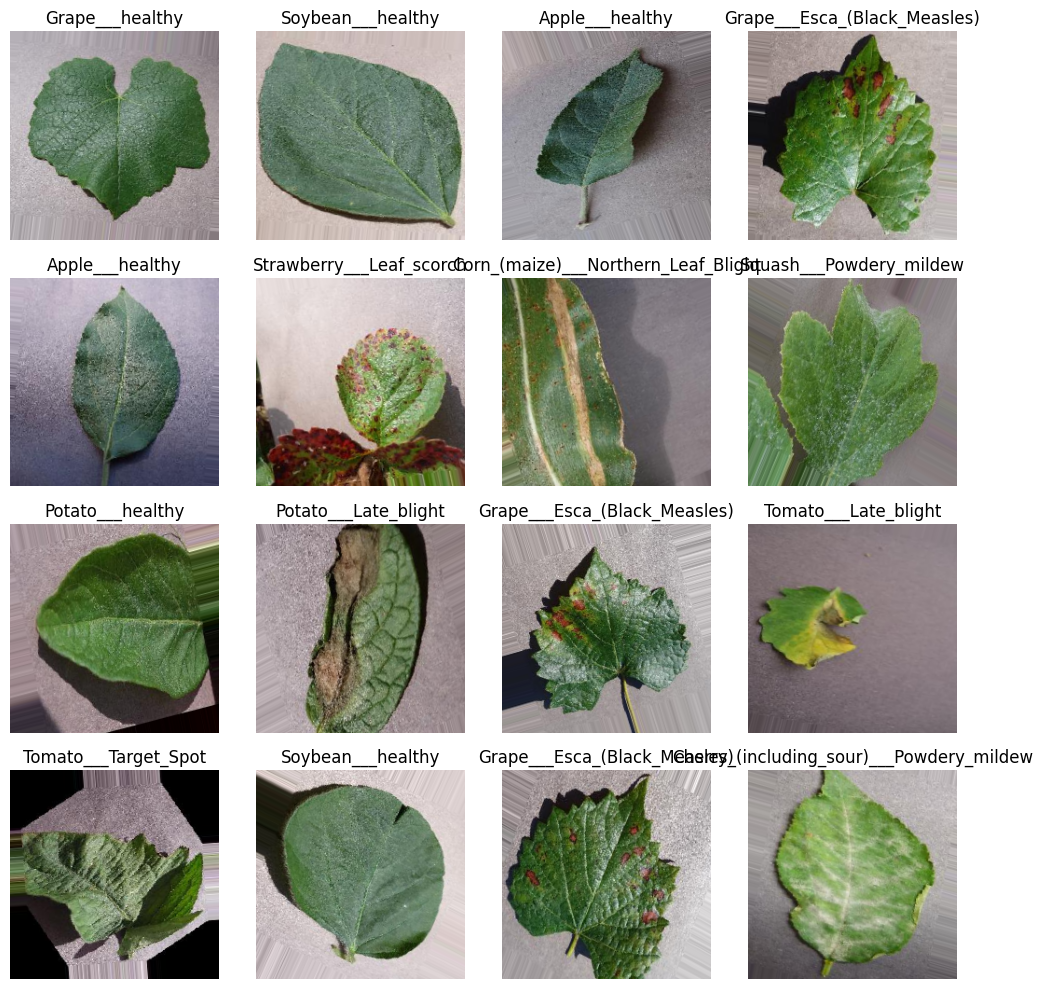

In [28]:
#Visualize sample images
class_names = list(train_gen.class_indices.keys())

# Visualize Samples
def show_samples(generator):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(x_batch[i])
        plt.title(class_names[np.argmax(y_batch[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_gen)



In [29]:
#Build the CNN model
from tensorflow import keras

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,821,414 (98.50 MB)

 Trainable params: 25,821,414 (98.50 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train the model (with optimized execution time)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,  # Increase for better accuracy
    steps_per_epoch=min(100, len(train_gen)),
    validation_steps=min(20, len(val_gen))
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 490s 5s/step - accuracy: 0.0320 - loss: 3.8197 - val_accuracy: 0.0891 - val_loss: 3.3808
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.0582 - loss: 3.5556 - val_accuracy: 0.1594 - val_loss: 3.2532
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 500s 5s/step - accuracy: 0.0707 - loss: 3.4448 - val_accuracy: 0.1953 - val_loss: 3.1984
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 504s 5s/step - accuracy: 0.0887 - loss: 3.3433 - val_accuracy: 0.3094 - val_loss: 2.7572
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 501s 5s/step - accuracy: 0.1188 - loss: 3.1488 - val_accuracy: 0.3297 - val_loss: 2.5142


In [33]:
#Evaluate the model
loss, acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")


550/550 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.2745 - loss: 2.7102

✅ Test Accuracy: 0.2553 | Test Loss: 2.6947


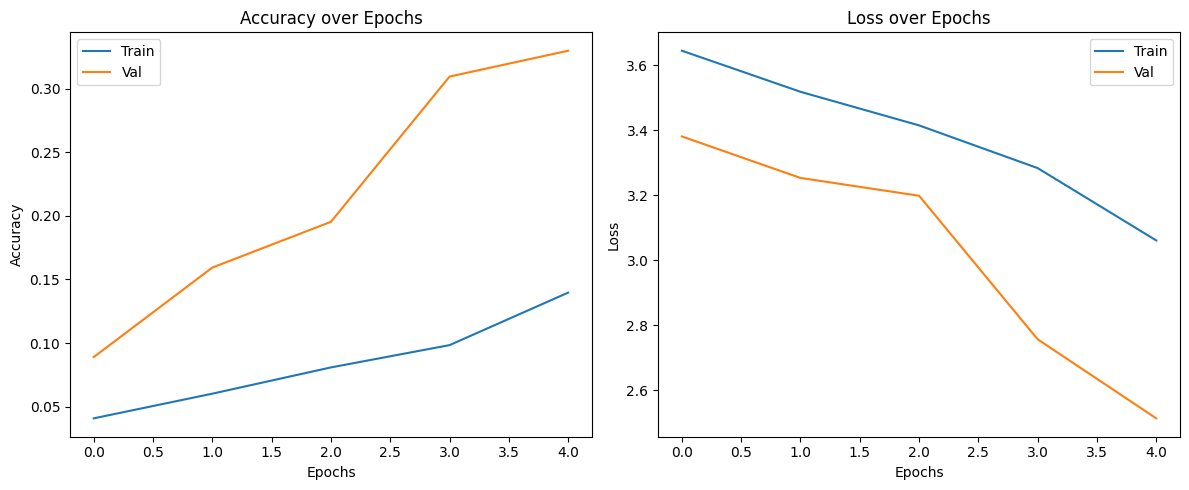

In [34]:
#Plot training history
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    for i, metric in enumerate(['accuracy', 'loss']):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Val')
        plt.title(f"{metric.capitalize()} over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


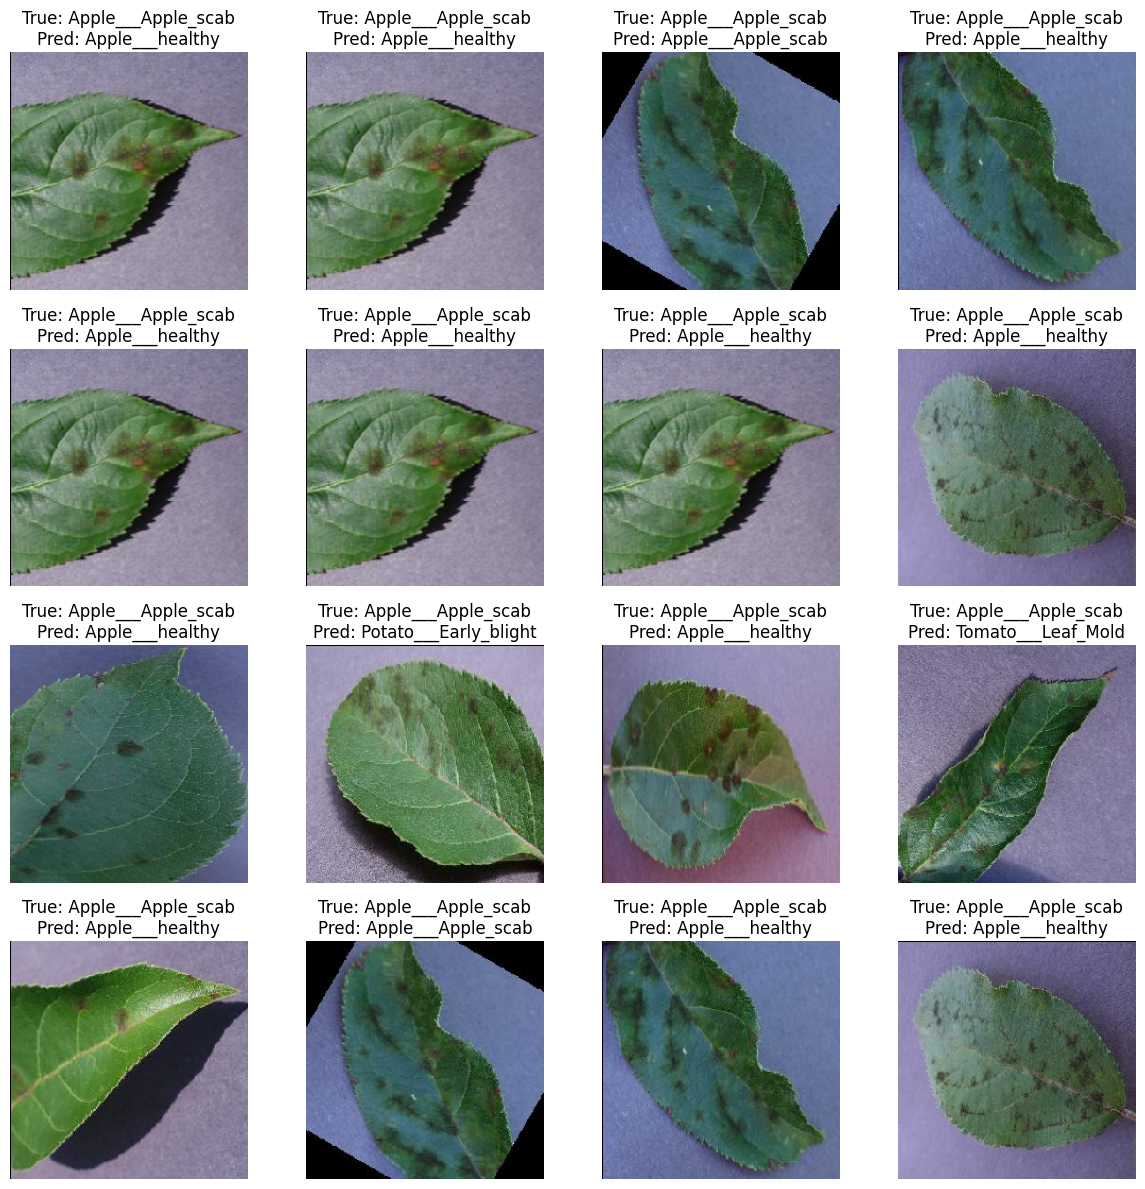

In [36]:
#Predict on some test images
x_test, y_test = next(test_gen)
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

plt.figure(figsize=(12, 12))
for i in range(16):
    idx = random.randint(0, len(x_test)-1)
    plt.subplot(4, 4, i+1)
    plt.imshow(x_test[idx])
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
